### Import the required libraries

In [ ]:
# import time
import time
t1 = time.time()

In [ ]:
import math
import random
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Making the results reproducible (knowing the random seed of the two libraries)

In [ ]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 97
tf_rand_seed = 82
np.random.seed(np_rand_seed)

# **1. Load and Inspect the data**

In [ ]:
data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Kaggle/Statoil C-CORE Iceberg Classifier Challenge/input/train.json')
test_data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Kaggle/Statoil C-CORE Iceberg Classifier Challenge/input/test.json')

In [ ]:
data.head(5)

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [ ]:
test_data.head(5)

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


In [ ]:
# train, test set의 크기 확인
print("Shape of train set:", data.shape)
#train set의 band_1, band_2 feature의 크기 확인print("Shape of test set:", test_data.shape)

Shape of train set: (1604, 5)


In [ ]:
# train set의 band_1, band_2 feature의 크기 확인
print("Shape of band 1:", np.shape(data.band_1.iloc[0]))
print("Shape of band 2:", np.shape(data.band_2.iloc[0]))

Shape of band 1: (5625,)
Shape of band 2: (5625,)


In [ ]:
# train set의 band_1, band_2 feature의 data type 확인
print("Type of band 1:",  type(data.band_1.iloc[0]))
print("Type of band 2:",  type(data.band_2.iloc[0]))

Type of band 1: <class 'list'>
Type of band 2: <class 'list'>


# **2. Feature Engineering**

## 2.1 Feature engineering on train set

### 2.1.1 Replacing the na in inc_anlge with mean**

In [ ]:
# train set의 inc_angle feature에서 결측치(na값)을 결측치가 없는 값들의 mean값으로 대치한다.
data[data['inc_angle']=='na'] = data[data['inc_angle']!='na']['inc_angle'].mean()

### 2.1.2 Converting the angle from degrees to radian**

In [ ]:
# inc_angle feature는 각도(0~360)으로 되어있는데, 이를 라디안 값으로 변환한다.
data['inc_angle'] = data['inc_angle'].apply(lambda x: math.radians(x))

In [ ]:
# 밑을 보면 inc_angle 값이 라디안 값으로 변환된 것을 볼 수 있다.
data.inc_angle.head()

0    0.766617
1    0.665951
2    0.790388
3    0.764988
4    0.621784
Name: inc_angle, dtype: float64

### 2.1.3 Finding and droping points with mismatch band1 and band2 data

Function which return the count and the index of mismatched data

일치하지 않는 데이터의 개수와 인덱스를 반환하는 함수

In [ ]:
# band_1/2 data의 크기는 원래 (5625,)인데, 몇 개 빠져있는 row들이 존재한다.
# 이를 찾아내기 위한 함수 find_missing_data
def find_missing_data(series, shape):
    
    '''function which return the count and the index of mismatched data'''

    count = 0
    missing_list = []
    for i, x in enumerate(series):
        if np.shape(series.iloc[i]) != shape:
            missing_list.append(i)
            count += 1
    
    return missing_list, count

Count and list of mismatched points in band1

band1에서 일치하지 않는 점의 개수 및 목록

In [ ]:
missing_list1, count1 = find_missing_data(data.band_1, (5625,))
print('count: ', count1)
print('missing data: ', missing_list1)

# 밑에 나온 값이 band_1 feature에서 shape가 (5625,)가 아닌 값들.

count:  133
missing data:  [101, 126, 142, 145, 176, 179, 191, 278, 286, 342, 412, 431, 440, 493, 642, 666, 667, 730, 741, 742, 763, 822, 863, 868, 906, 916, 996, 1041, 1065, 1095, 1199, 1228, 1247, 1257, 1268, 1290, 1345, 1403, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603]


Count and list of mismatched points in band2

band2에서 일치하지 않는 점의 개수 및 목록

In [ ]:
missing_list2, count2 = find_missing_data(data.band_2, (5625,))
print('count: ', count2)
print('missing data: ', missing_list2)

count:  133
missing data:  [101, 126, 142, 145, 176, 179, 191, 278, 286, 342, 412, 431, 440, 493, 642, 666, 667, 730, 741, 742, 763, 822, 863, 868, 906, 916, 996, 1041, 1065, 1095, 1199, 1228, 1247, 1257, 1268, 1290, 1345, 1403, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603]


Check if the missing points are same

누락된 점이 동일한지 확인

In [ ]:
# 같은 배열이다. 빠진 것이 나타나는 row가 같다.
missing_list1 == missing_list2

True

Function to drop data by index

인덱스별로 데이터를 삭제하는 함수

In [ ]:
# index에 대해 데이터를 삭제해주는 함수 drop_data
def drop_data(df, index):

    '''function to drop data by index'''

    return df.drop(df.index[index])

Drop the points with mismatched images

일치하지 않는 이미지로 포인트 삭제

In [ ]:
# 위의 missing_list1를 이용해 train에서 해당 값을 제거
data = drop_data(data, missing_list1)

In [ ]:
data.shape

(1471, 5)

In [ ]:
print("Number of positive classes: ", len(data[data['is_iceberg'] == 1.0]))
print("Number of negative classes: ", len(data[data['is_iceberg'] == 0.0]))

Number of positive classes:  753
Number of negative classes:  718


### 2.1.4 Scale the image data

3 standardization to technique we can try on

3개의 시도할 수 있는 기술에 대한 표준화

In [ ]:
def standardise_vector(vector):

    '''standardise vector'''
    
    standardised_vector = (np.array(vector) - np.mean(vector)) / np.std(vector)
    return standardised_vector.tolist()

In [ ]:
def mean_normalise_vector(vector):

    '''mean normalize vector'''
    
    normalised_vector = (np.array(vector) - np.mean(vector)) / (np.max(vector) - np.min(vector))
    return normalised_vector.tolist()

In [ ]:
def min_max_scaler(vector, minimum=0, maximum=1):
    
    '''minmaxscaler'''

    X_std = (np.array(vector) - np.min(vector)) / (np.max(vector) - np.min(vector))
    scaled_vector = X_std * (maximum - minimum) + minimum
    return scaled_vector.tolist()

We will use standardisation as the normalization technique since this works well with images

이것은 이미지와 잘 작동하기 때문에 표준화 기술로 표준화를 사용할 것입니다.

In [ ]:
# 1번 기법 standardise_vector 사용
data['band_1'] = data['band_1'].apply(standardise_vector)
data['band_2'] = data['band_2'].apply(standardise_vector)

In [ ]:
data.head(5)

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[0.01182174564467684, 0.27378275943768166, -0....","[1.1573585860406173, 0.15631457838356574, -0.4...",0.766617,0.0
1,e25388fd,"[0.42137323598577087, -0.43078366534450846, -0...","[-2.0950953014724543, -0.8948057535299927, -0....",0.665951,0.0
2,58b2aaa0,"[-0.6969623073924855, -0.6969793944501068, -0....","[-0.014649839717716016, 0.35157292381049343, 1...",0.790388,1.0
3,4cfc3a18,"[0.2946591706447792, 0.04985985071106006, -0.3...","[0.7023040788844376, 0.8569610477684707, 1.005...",0.764988,0.0
4,271f93f4,"[-0.31533024179271146, 0.9175181439939705, 0.9...","[-0.693769690678262, -2.0346940986353044, -2.0...",0.621784,0.0


### 2.1.5 Reshaping the band1 and band2 data into 2D image

In [ ]:
band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data['band_1']])
band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])

In [ ]:
print('Shape of band 1 image:', band_1.shape)
print('Shape of band 2 image:', band_2.shape)

# (1471,5625)가 (1471,75,75)로 변화 -> 2D image로 변환 (추후 Conv2D 연산을 위해 N x Height x Width 꼴로 변환)
# 원래는 N x Height x Width x Channel 꼴로 변환해야 하는데, Channel은 밑에서 추가함.

Shape of band 1 image: (1471, 75, 75)
Shape of band 2 image: (1471, 75, 75)


## 2.2 Feature engieering on test Set

We carry out the same feature engineering as carried out on train set

우리는 훈련 세트에서 수행된 것과 동일한 feature 엔지니어링을 수행합니다.

In [ ]:
# 2.2와 같은 작업을 수행
test_data['inc_angle'] = test_data['inc_angle'].apply(lambda x: math.radians(x))

In [ ]:
test_data.inc_angle.head()

0    0.610279
1    0.569240
2    0.654593
3    0.601683
4    0.766529
Name: inc_angle, dtype: float64

In [ ]:
missing_list3, count3 = find_missing_data(test_data.band_1, (5625,))
print('count: ', count3)
print('missing data: ', missing_list3)

count:  0
missing data:  []


In [ ]:
missing_list4, count4 = find_missing_data(test_data.band_2, (5625,))
print('count: ', count4)
print('missing data: ', missing_list4)

count:  0
missing data:  []


In [ ]:
test_data['band_1'] = test_data['band_1'].apply(standardise_vector)
test_data['band_2'] = test_data['band_2'].apply(standardise_vector)

In [ ]:
band_1_test = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_data['band_1']])
band_2_test = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_data['band_2']])

In [ ]:
print('Shape of test set band 1 image:', band_1_test.shape)
print('Shape of test set band 2 image:', band_2_test.shape)

Shape of test set band 1 image: (8424, 75, 75)
Shape of test set band 2 image: (8424, 75, 75)


# **3. Train/test/validation split**

Extract the labels and angles of train set

훈련 세트의 레이블 및 각도 추출

In [ ]:
# 판다스 0.23.0부터 이 메서드는 더 이상 사용하지 않게 되어
# 동일한 일을 수행하는 다른 메서드인 DataFrame.to_numpy()를 사용
labels = data.is_iceberg.to_numpy()
angles = data.inc_angle.to_numpy()

Carry out splits

분할 수행

In [ ]:
# randomly choosing the train and calidation indices
train_indices = np.random.choice(len(labels), round(len(labels)*0.75), replace=False)
validation_indices = np.array(list(set(range(len(labels))) - set(train_indices)))

# extract train set
band_1_train = band_1[train_indices]
band_2_train = band_2[train_indices]
angles_train = angles[train_indices]
labels_train = labels[train_indices]

# extract validation set
band_1_validation = band_1[validation_indices]
band_2_validation = band_2[validation_indices]
angles_validation = angles[validation_indices]
labels_validation = labels[validation_indices]

# extract test set
band_1_test = band_1_test
band_2_test = band_2_test
angles_test = test_data.inc_angle.to_numpy()
iD = test_data.id.to_numpy()

Covert the types of all data to float

모든 데이터의 유형을 float으로 변환

In [ ]:
band_1_train = band_1_train.astype(np.float32)
band_1_validation = band_1_validation.astype(np.float32)
band_1_test = band_1_test.astype(np.float32)

band_2_train = band_2_train.astype(np.float32)
band_2_validation = band_2_validation.astype(np.float32)
band_2_test = band_2_test.astype(np.float32)

angles_train = angles_train.astype(np.float32)
angles_validation = angles_validation.astype(np.float32)
angles_test = angles_test.astype(np.float32)

labels_train = labels_train.astype(np.float32)
labels_validation = labels_validation.astype(np.float32)
iD = iD.astype(np.str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [ ]:
# delete the unnecessary variables out of memory
del(data, test_data, band_1, band_2)

Examine the shape of the data

데이터의 형태 조사

In [ ]:
print('Shape of band_1_train:', band_1_train.shape)
print('Shape of band_2_train:', band_1_train.shape)
print('Shape of angles_train:', angles_train.shape)
print('Shape of labels_train:', labels_train.shape)

print('Shape of band_1_validation:', band_1_validation.shape)
print('Shape of band_2_validation:', band_2_validation.shape)
print('Shape of angles_validation:', angles_validation.shape)
print('Shape of labels_validation:', labels_validation.shape)

print('Shape of band_1_test:', band_1_test.shape)
print('Shape of band_2_test:', band_2_test.shape)
print('Shape of angles_test:', angles_test.shape)
print('Shape of iD:', iD.shape)

Shape of band_1_train: (1103, 75, 75)
Shape of band_2_train: (1103, 75, 75)
Shape of angles_train: (1103,)
Shape of labels_train: (1103,)
Shape of band_1_validation: (368, 75, 75)
Shape of band_2_validation: (368, 75, 75)
Shape of angles_validation: (368,)
Shape of labels_validation: (368,)
Shape of band_1_test: (8424, 75, 75)
Shape of band_2_test: (8424, 75, 75)
Shape of angles_test: (8424,)
Shape of iD: (8424,)


# **4. Augmenting train set**

## 4.1 Functions to carry out different augmentation technique

### 4.1.1 Image Rotation

In [ ]:
# 이미지 회전
def rotate_image(img, angle = 20):
    
    '''a function to rotate image by a given degree'''
    
    # rotate image
    original = img.copy()

    # cv2.getRotationMatrix2D(회전 중심 좌표, 반시계 방향의 회전 각도, 추가적인 확대 비율)
    M_rotate = cv2.getRotationMatrix2D((37,37),angle,1)
    
    # cv2.warpAffine(대상 이미지, Affine Matrix, 이미지 크기)
    img_new = cv2.warpAffine(img,M_rotate,(75,75))
    
    length_row = 0
    length_column = 0
    boundary_step = 5
    
    for i in range(len(img_new)):
        if img_new[0,i]!=float(0.0):
            length_row = i
            break
    for i in range(len(img_new)):
        if img_new[i,0]!=float(0.0):
            length_column = i
            break
    
    # subsitute the padding from original image
    img_new[:length_column+boundary_step,:length_row+boundary_step] = \
    original[:length_column+boundary_step,:length_row+boundary_step] 
    img_new[-(length_row+boundary_step):,:length_column+boundary_step] = \
    original[-(length_row+boundary_step):,:length_column+boundary_step]
    img_new[:length_row+boundary_step,-(length_column+boundary_step):] = \
    original[:length_row+boundary_step,-(length_column+boundary_step):]
    img_new[-(length_column+boundary_step):,-(length_row+boundary_step):] = \
    original[-(length_column+boundary_step):,-(length_row+boundary_step):]
    
    return img_new

### 4.1.2 Horizontal translation

In [ ]:
# 수평 방향으로 움직이기(shift)
def translate_horizontal(image, shift_horizontal = 5):
    
    '''a function to translate image horizontally by a shift'''
    
    # horizontally shift image
    img = image.copy()
    
    shift_vertical = 0; 
    if shift_horizontal<0:
        image_slice = img[:,shift_horizontal:].copy()
    if shift_horizontal>0:
        image_slice = img[:,:shift_horizontal].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_horizontal<0:
        img_new[:,shift_horizontal:] = image_slice
    if shift_horizontal>0:
        img_new[:,:shift_horizontal] = image_slice
        
    return img_new.reshape(75,75).astype(np.float32)

### 4.1.3 Vertical translation

In [ ]:
# 수직으로 움직이기(vertical shift)
def translate_vertical(image, shift_vertical = 5):
    
    '''a function to translate image vertically by a shift'''
    
    # vertically shift image
    img = image.copy()
    
    shift_horizontal = 0;
    if shift_vertical<0:
        image_slice = img[shift_vertical:,:].copy()
    if shift_vertical>0:
        image_slice = img[:shift_vertical,:].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_vertical<0:
        img_new[shift_vertical:,:] = image_slice
    if shift_vertical>0:
        img_new[:shift_vertical,:] = image_slice
        
    return img_new.reshape(75,75).astype(np.float32)

### 4.1.4 Translation along positive diagonal

In [ ]:
# 대각선으로 움직이기(diagonal shift)
def translate_positive_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along positive diagonal'''
    
    # translate image along positive diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[shift_diagonal:,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    else:
        hor_slice = img[:shift_diagonal,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_diagonal<0:
        img_new[shift_diagonal:,:] = hor_slice
        img_new[:,shift_diagonal:] = ver_slice
    else:
        img_new[:shift_diagonal,:] = hor_slice
        img_new[:,:shift_diagonal] = ver_slice
    
    return img_new.reshape(75,75).astype(np.float32)

### 4.1.5 Translation along negative diagonal

In [ ]:
# 대각선으로 움직이기(diagonal shift) - 음의 방향
def translate_negative_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along negative diagonal'''
    
    # translate image along negative diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[:-shift_diagonal,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    if shift_diagonal>0:
        hor_slice = img[-shift_diagonal:,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,-shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_diagonal<0:
        img_new[:-shift_diagonal,:] = hor_slice
        img_new[:,shift_diagonal:] = ver_slice
    if shift_diagonal>0:
        img_new[-shift_diagonal:,:] = hor_slice
        img_new[:,:shift_diagonal] = ver_slice
        
    return img_new.reshape(75,75).astype(np.float32)

### 4.1.6 Flip Image

In [ ]:
# 이미지 플립
def flip(image, direction = 0):
    
    '''a function to flip image'''
    img = image.copy()
    return cv2.flip(img,direction)

### 4.1.7 Zoom image

In [ ]:
# 이미지 확대
def zoom(image, zoom_shift = 5):
    
    '''a function to zoom image'''
    
    # zoom image
    img = image.copy()
    
    # zoom in 
    if zoom_shift>0:
        # scale
        img_new = cv2.resize(img, (75+zoom_shift*2,75+zoom_shift*2)) 
        # crop
        img_new = img_new[zoom_shift:-zoom_shift,zoom_shift:-zoom_shift] 
    # zoom out
    else:
        zoom_shift *=-1
        
        hor_top = img[:zoom_shift,:]
        hor_bottom =img[-zoom_shift:,:]
        ver_left = img[:,:zoom_shift]
        ver_right = img[:,-zoom_shift:]
        
        # scale
        img_new = cv2.resize(img, (75-zoom_shift*2,75-zoom_shift*2)) 
        # zero padding
        img_new = cv2.copyMakeBorder(img_new,zoom_shift,zoom_shift,zoom_shift,zoom_shift,
                                     cv2.BORDER_CONSTANT,value=0.0)
        # subsitute the padding from original image
        img_new[:zoom_shift,:] = hor_top
        img_new[-zoom_shift:,:] = hor_bottom
        img_new[:,:zoom_shift] = ver_left
        img_new[:,-zoom_shift:] = ver_right     
        
    return img_new.reshape(75,75).astype(np.float32)


## 4.2 Displaying augmented samples

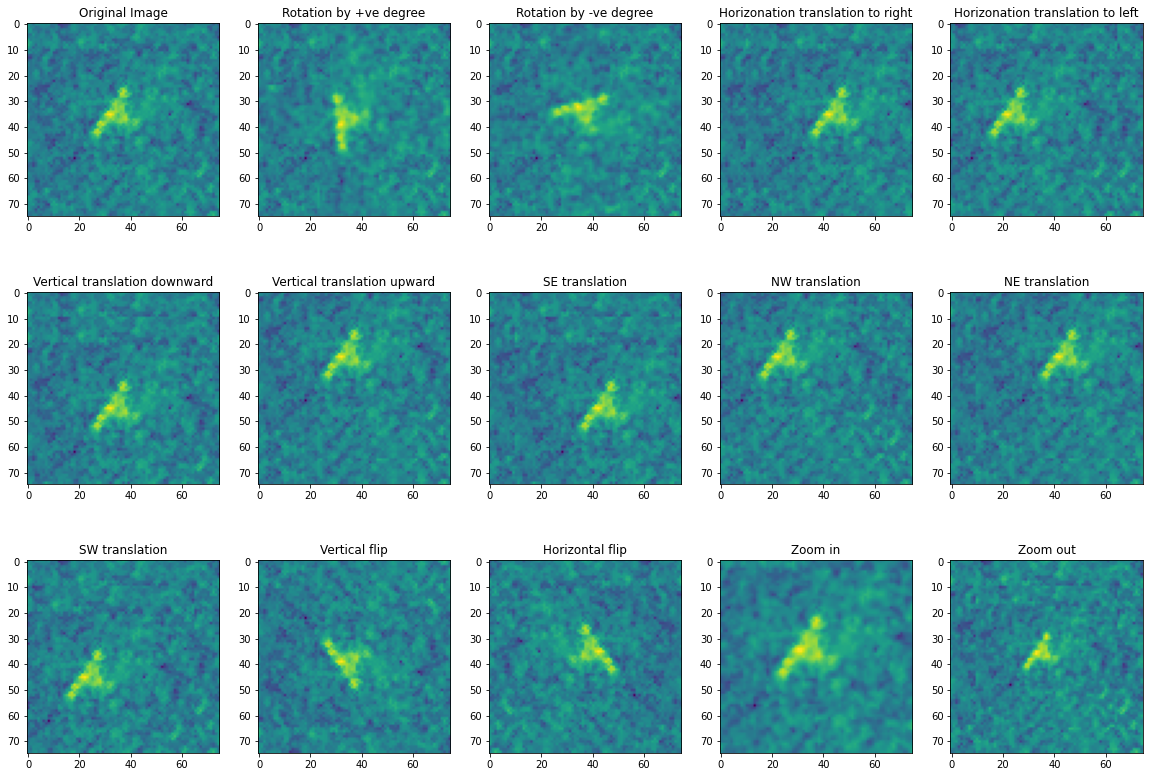

In [ ]:
matplotlib.rcParams['figure.figsize'] = (20.0, 14.0)


image = band_1_test[3].copy()
plt.subplot(3, 5, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(3, 5, 2)
generated_image = rotate_image(image, 40)
plt.title("Rotation by +ve degree")
plt.imshow(generated_image)

plt.subplot(3, 5, 3)
generated_image = rotate_image(image, -40)
plt.title("Rotation by -ve degree")
plt.imshow(generated_image)

plt.subplot(3, 5, 4)
generated_image = translate_horizontal(image, 10)
plt.title("Horizonation translation to right")
plt.imshow(generated_image)

plt.subplot(3, 5, 5)
generated_image = translate_horizontal(image, -10)
plt.title("Horizonation translation to left")
plt.imshow(generated_image)

plt.subplot(3, 5, 6)
generated_image = translate_vertical(image, 10)
plt.title("Vertical translation downward")
plt.imshow(generated_image)

plt.subplot(3, 5, 7)
generated_image = translate_vertical(image, -10)
plt.title("Vertical translation upward")
plt.imshow(generated_image)

plt.subplot(3, 5, 8)
generated_image = translate_positive_diagonal(image, 10)
plt.title("SE translation")
plt.imshow(generated_image)

plt.subplot(3, 5, 9)
generated_image = translate_positive_diagonal(image, -10)
plt.title("NW translation")
plt.imshow(generated_image)

plt.subplot(3, 5, 10)
generated_image = translate_negative_diagonal(image, 10)
plt.title("NE translation")
plt.imshow(generated_image)

plt.subplot(3, 5, 11)
generated_image = translate_negative_diagonal(image, -10)
plt.title("SW translation")
plt.imshow(generated_image)

plt.subplot(3, 5, 12)
generated_image = flip(image, 0)
plt.title("Vertical flip")
plt.imshow(generated_image)

plt.subplot(3, 5, 13)
generated_image = flip(image, 1)
plt.title("Horizontal flip")
plt.imshow(generated_image)

plt.subplot(3, 5, 14)
generated_image = zoom(image, 10)
plt.title("Zoom in")
plt.imshow(generated_image)

plt.subplot(3, 5, 15)
generated_image = zoom(image, -10)
plt.title("Zoom out")
plt.imshow(generated_image)

plt.show()

## 4.3 Augmentation of train set

In [ ]:
def augment_data(band1, band2, angles, labels):

    '''a function to augment band1 and band2 image'''

    # list to store the generated data
    band1_generated = []
    band2_generated = []
    angles_generated = []
    labels_generated = []

    # iterate throught each point in train set
    for i in range(labels.shape[0]):

        # rotate by positive degree
        angle = np.random.randint(5, 20)
        band1_generated.append(rotate_image(band1[i], angle)) 
        band2_generated.append(rotate_image(band2[i], angle))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # rotate by negative degree
        angle = np.random.randint(5, 20)
        band1_generated.append(rotate_image(band1[i], -angle)) 
        band2_generated.append(rotate_image(band2[i], -angle))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # positive horizontal shift
        shift = np.random.randint(3, 7)
        band1_generated.append(translate_horizontal(band1[i], +shift)) 
        band2_generated.append(translate_horizontal(band2[i], +shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # negative horizontal shift
        shift = np.random.randint(3, 7) 
        band1_generated.append(translate_horizontal(band1[i], -shift)) 
        band2_generated.append(translate_horizontal(band2[i], -shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # positive vertical shift
        shift = np.random.randint(0, 7)  
        band1_generated.append(translate_vertical(band1[i], +shift)) 
        band2_generated.append(translate_vertical(band2[i], +shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # negative vertical shift
        shift = np.random.randint(3, 7) 
        band1_generated.append(translate_vertical(band1[i], -shift)) 
        band2_generated.append(translate_vertical(band2[i], -shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in positive direction
        shift = np.random.randint(3, 7)  
        band1_generated.append(translate_positive_diagonal(band1[i], +shift)) 
        band2_generated.append(translate_positive_diagonal(band2[i], +shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in negative direction
        shift = np.random.randint(3, 7)  
        band1_generated.append(translate_positive_diagonal(band1[i], -shift)) 
        band2_generated.append(translate_positive_diagonal(band2[i], -shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in positive direction
        shift = np.random.randint(3, 7)   
        band1_generated.append(translate_negative_diagonal(band1[i], +shift)) 
        band2_generated.append(translate_negative_diagonal(band2[i], +shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in negative direction
        shift = np.random.randint(3, 7)   
        band1_generated.append(translate_negative_diagonal(band1[i], -shift)) 
        band2_generated.append(translate_negative_diagonal(band2[i], -shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # vertical flip
        band1_generated.append(flip(band1[i], 0)) 
        band2_generated.append(flip(band2[i], 0))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # horizontal flip
        band1_generated.append(flip(band1[i], 1)) 
        band2_generated.append(flip(band2[i], 1))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # zoom in image
        zoom_shift = np.random.randint(2, 5)
        band1_generated.append(zoom(band1[i], zoom_shift)) 
        band2_generated.append(zoom(band2[i], zoom_shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # zoom out image
        zoom_shift = np.random.randint(2, 5) 
        band1_generated.append(zoom(band1[i], -zoom_shift)) 
        band2_generated.append(zoom(band2[i], -zoom_shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])        
        
    # convert the generated data into numpy array
    band1_generated = np.array(band1_generated)
    band2_generated = np.array(band2_generated)
    angles_generated = np.array(angles_generated)
    labels_generated = np.array(labels_generated)
    
    # concatenate the generated data to original train set
    band1_augmented = np.concatenate((band1, band1_generated), axis=0)
    band2_augmented = np.concatenate((band2, band2_generated), axis=0)
    angles_augmented = np.concatenate((angles, angles_generated), axis=0)
    labels_augmented = np.concatenate((labels, labels_generated), axis=0)
    
    return band1_augmented, band2_augmented, angles_augmented, labels_augmented


In [ ]:
# augment train set
band_1_train, band_2_train, angles_train, labels_train = \
    augment_data(band_1_train, band_2_train, angles_train, labels_train)

Examine the shape of augmented data

증강 데이터의 형태 조사

In [ ]:
print('Shape of band_1_train:', band_1_train.shape)
print('Shape of band_2_train:', band_2_train.shape)
print('Shape of angles_train:', angles_train.shape)
print('Shape of labels_train:', labels_train.shape)

Shape of band_1_train: (16545, 75, 75)
Shape of band_2_train: (16545, 75, 75)
Shape of angles_train: (16545,)
Shape of labels_train: (16545,)


# **5. Concatenate the band1 and band2 data into 3D image**

Here we stack band_1, band_2, and average of the two to create a 3D image

여기에 band_1, band_2 및 둘의 평균을 쌓아 3D 이미지를 만듭니다.

In [ ]:
image_train = np.concatenate([band_1_train[:, :, :, np.newaxis],
                              band_2_train[:, :, :, np.newaxis],
                              ((band_1_train + band_2_train)/2)[:, :, :, np.newaxis]],
                              axis=-1)

In [ ]:
image_validation = np.concatenate([band_1_validation[:, :, :, np.newaxis],
                                   band_2_validation[:, :, :, np.newaxis],
                                   ((band_1_validation+band_2_validation)/2)[:, :, :, np.newaxis]],
                                   axis=-1)

In [ ]:
image_test = np.concatenate([band_1_test[:, :, :, np.newaxis],
                             band_2_test[:, :, :, np.newaxis],
                             ((band_1_test+band_2_test)/2)[:, :, :, np.newaxis]],
                             axis=-1)

In [ ]:
# delete the unnecessary variables out of memory
del(band_1_train, band_1_validation, band_1_test, band_2_train, band_2_validation, band_2_test)

Examine the shape of 3D images

3D 이미지의 모양 검사

In [ ]:
print('Shape of image_train:', image_train.shape)
print('Shape of image_validation:', image_validation.shape)
print('Shape of image_test:', image_test.shape)

Shape of image_train: (16545, 75, 75, 3)
Shape of image_validation: (368, 75, 75, 3)
Shape of image_test: (8424, 75, 75, 3)


# **6. Creating Convolutional Neural Network**

Import tensorflow and reset default graph

tensorflow 가져오기 및 기본 그래프 재설정

In [ ]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
tf.compat.v1.set_random_seed(tf_rand_seed) #원본 노트북은 TensorFlow 1.x 버전 기준인데, Kaggle Notebook은 TensorFlow 2.x버전이기 때문에, 2.x에서 1.x 코드로 변환했다.
#이하로 compat.v1이 붙는 메서드는 전부 2.x에서 1.x 코드를 돌아가게 하는 방법이다.

## 6.1 One hot encoding labels

In [ ]:
labels_train = pd.get_dummies(labels_train).to_numpy()
labels_validation = pd.get_dummies(labels_validation).to_numpy()

In [ ]:
print("Shape of labels_train:", labels_train.shape)
print("Shape of labels_validation:", labels_validation.shape)

Shape of labels_train: (16545, 2)
Shape of labels_validation: (368, 2)


## 6.2 Create placeholders

In [ ]:
# image dimensions
width = 75
height = 75
num_channels = 3
flat = width * height
num_classes = 2

Create placeholder for image, labels, dropout keep probability, and optionally angle

이미지, 레이블, 드롭아웃 유지 확률 및 선택적으로 각도에 대한 자리 표시자 만들기

In [ ]:
tf.compat.v1.disable_eager_execution() #TensorFlow 1.x에서 TensorFlow 2.x로 올라갈 때 생기는 오류 방지

#tf.placeholder(TF 1.x) -> tf.compat.v1.placeholder(TF 2.x)

image = tf.compat.v1.placeholder(tf.float32, shape=[None, height, width, num_channels])
y_true = tf.compat.v1.placeholder(tf.int32, shape=[None, num_classes])
keep_prob = tf.compat.v1.placeholder(tf.float32)

## 6.3 Create functions for creating deep learning layers

In [ ]:
#가중치 텐서 생성
def create_weights(shape):
    return tf.Variable(tf.random.truncated_normal(shape, stddev=0.05))

#바이어스 텐서 생성 
def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [ ]:
#컨볼루션 층 만드는 함수
def create_convolutional_layer(input, num_input_channels, conv_filter_size, max_pool_filter_size, num_filters):  

    #컨볼루션 층의 필터 만들기
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    
    # 바이어스 값 만들기
    biases = create_biases(num_filters)
    
    # 컨볼루션 층 생성
    layer = tf.nn.conv2d(input=input, filters=weights, strides=[1, 1, 1, 1], padding='SAME')
    
    # 컨볼루션 층에 바이어스 값 더하기
    layer += biases
    
    # ReLU 활성함수 통과
    layer = tf.nn.relu(layer)
    
    # 맥스 풀링을 통해 이미지 사이즈를 절반으로 줄이기
    layer = tf.nn.max_pool2d(input=layer, ksize=[1, max_pool_filter_size, max_pool_filter_size, 1], strides=[1, 2, 2, 1], padding='SAME')
        
    # output layer return
    return layer

In [ ]:
#컨볼루션 층을 지난 것을 flatten하게 해주는 함수
def create_flatten_layer(layer):

    # layer의 size 저장
    layer_shape = layer.get_shape()
    
    #flatten layer가 어떤 shape를 가져야할지 num_features에 저장
    num_features = layer_shape[1:4].num_elements()
    
    
    # flatten layer 만들기
    layer = tf.reshape(layer, [-1, num_features])
    
    return layer

In [ ]:
#fully connected layer 만드는 함수
def create_fc_layer(input, num_inputs, num_outputs, use_relu=True, dropout = False, keep_prob = 0.2):
    

    #가중치와 바이어스값 만들기
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    # Wx+b 함수 생성 <- 가장 기본 적인 것
    # matrix multiplication between input and weight matrix
    layer = tf.matmul(input, weights) + biases
    
    # ReLU
    if use_relu:
        layer = tf.nn.relu(layer)
        
    # Dropout
    if dropout:        
        layer = tf.nn.dropout(layer, rate=1 - (keep_prob))
    
    return layer

## 6.4 Create Layers of Covnet

In [ ]:
# parameters for 1st convolutional layer
conv1_features = 64
conv1_filter_size = 3
max_pool_size1 = 2

# parameters for 2nd convolutional layer
conv2_features = 128
conv2_filter_size = 3
max_pool_size2 = 2

# parameters for 3rd convolutional layer
conv3_features = 128
conv3_filter_size = 3
max_pool_size3 = 2

# parameters for 4th convolutional layer
conv4_features = 64
conv4_filter_size = 3
max_pool_size4 = 2

# number of featuers of 1st fully connected layer
fc_layer_size1 = 512

# number of featuers of 2nd fully connected layer
fc_layer_size2 = 256

Create convolutional layer 1

In [ ]:
#layer 1
layer_conv1 = create_convolutional_layer(input=image,
                                         num_input_channels= num_channels,
                                         conv_filter_size = conv1_filter_size,
                                         max_pool_filter_size = max_pool_size1,
                                         num_filters = conv1_features)
layer_conv1

<tf.Tensor 'MaxPool2d:0' shape=(None, 38, 38, 64) dtype=float32>

Create convolutional layer 2

In [ ]:
layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                         num_input_channels=conv1_features,
                                         conv_filter_size=conv2_filter_size,
                                         max_pool_filter_size=max_pool_size2,
                                         num_filters=conv2_features)
layer_conv2

<tf.Tensor 'MaxPool2d_1:0' shape=(None, 19, 19, 128) dtype=float32>

Create convolutional layer 3

In [ ]:
layer_conv3 = create_convolutional_layer(input=layer_conv2,
                                         num_input_channels=conv2_features,
                                         conv_filter_size=conv3_filter_size,
                                         max_pool_filter_size=max_pool_size3,
                                         num_filters=conv3_features)
layer_conv3

<tf.Tensor 'MaxPool2d_2:0' shape=(None, 10, 10, 128) dtype=float32>

Create convolutional layer 4

In [ ]:
layer_conv4 = create_convolutional_layer(input=layer_conv3,
                                         num_input_channels=conv3_features,
                                         conv_filter_size=conv4_filter_size,
                                         max_pool_filter_size=max_pool_size4,
                                         num_filters=conv4_features)
layer_conv4

<tf.Tensor 'MaxPool2d_3:0' shape=(None, 5, 5, 64) dtype=float32>

Flatten the output of last convolutional layer

In [ ]:
layer_flat = create_flatten_layer(layer_conv4)
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(None, 1600) dtype=float32>

Create the first fully connected layer

In [ ]:
layer_fc1 = create_fc_layer(input=layer_flat,
                            num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=fc_layer_size1,
                            use_relu=True,
                            dropout=True,
                            keep_prob=keep_prob)
layer_fc1

<tf.Tensor 'dropout_2/Mul:0' shape=(None, 512) dtype=float32>

Create the second fully connected layer

In [ ]:
layer_fc2 = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size1,
                            num_outputs=fc_layer_size2,
                            use_relu=True,
                            dropout=True,
                            keep_prob=keep_prob)
layer_fc2

<tf.Tensor 'dropout_3/Mul:0' shape=(None, 256) dtype=float32>

Create the output layer

In [ ]:
output_layer = create_fc_layer(input=layer_fc2,
                     num_inputs = fc_layer_size2,
                     num_outputs = num_classes,
                     use_relu=False)
output_layer

<tf.Tensor 'add_14:0' shape=(None, 2) dtype=float32>

## 6.5 Create prediction & accuracy metric

In [ ]:
# softmax operation on the output layer
y_pred = tf.nn.softmax(output_layer)

# extract the vector of predicted class
y_pred_cls = tf.argmax(y_pred, axis=1, output_type=tf.int32)

# extract the vector of labels
y_true_cls = tf.argmax(y_true, axis=1, output_type=tf.int32)

In [ ]:
# extract the vector of correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# operation to calculate accuracy
accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))

## 6.6 Create Optimizer

In [ ]:
# operation to calculate cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output_layer,
                                                    labels=y_true)

# mean of cross entropy to act as the loss
loss = tf.reduce_mean(input_tensor=cross_entropy)

In [ ]:
# sess.run(tf.global_variables_initializer())
# loss.eval(feed_dict={image: image_validation,
#                          angle: np.transpose([angles_validation]),
#                          y_true: labels_validation, keep_prob: 1.0})

In [ ]:
# learning rate of optimizer
learning_rate = (1e-3) * 0.30

# train step
train_step = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# **7. Train Model**

In [ ]:
# lists to store the train loss, validation loss, validation accuracy at each iteration
train_loss = []
valid_loss = []
valid_acc = []

# batch size
batch_size = 255

# max iteration
max_iter = 700

Here we train and save the model with the highest accuracy or lowest loss. But here I think it is wise to save the model with lowest loss

In [ ]:
# saver: model 중간 저장
saver = tf.compat.v1.train.Saver(max_to_keep=1)

# variables to store the accuracy, loss, iteration of our best model
best_accuracy = 0
best_loss = 1000000
best_iteration = None

iteration = 0

# create a graph session and optimize under it
with tf.compat.v1.Session() as sess:
    
    # initialize variables
    sess.run(tf.compat.v1.global_variables_initializer())

    # while 57 minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < 3420:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        # randomly choosing the indices of the batch 
        rand_index = np.random.choice(labels_train.shape[0], size=batch_size)

        # extract the batch image and labels
        image_rand = image_train[rand_index]
#         angles_rand = angles_train[rand_index]
        labels_rand = labels_train[rand_index]

        # feed dictionary for batch
        feed_dict_batch =  {image: image_rand,
#                             angle: np.transpose([angles_rand]),
                            y_true: labels_rand,
                            keep_prob: 0.7}
        # feed dictionary for train
        feed_dict_train =  {image: image_rand,
#                             angle: np.transpose([angles_rand]),
                            y_true: labels_rand,
                            keep_prob: 1.0}
        # feed dictionary for validation
        feed_dict_validation =  {image: image_validation,
#                                  angle: np.transpose([angles_validation]),
                                 y_true: labels_validation,
                                 keep_prob: 1.0}
        
        # 최적화 작업 종료
        sess.run(train_step, feed_dict=feed_dict_batch)

        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        # calculate temporary validation accuracy and append it to the designated list
        temp_validation_accuracy = accuracy.eval(session=sess, feed_dict=feed_dict_validation)
        valid_acc.append(temp_validation_accuracy)
        
        #valid loss가 best loss와 같고 accuracy가 best accuracy보다 좋으면 best model의 파라미터 갱신 후 저장
        if (temp_validation_loss == best_loss) and (temp_validation_accuracy > best_accuracy):
            best_accuracy = temp_validation_accuracy
            best_loss = temp_validation_loss
            best_iteration = iteration           
            saver.save(sess, './my-model', global_step = best_iteration)
        
        # valid accuray가 더 좋으면 best accuracy 갱신
        if temp_validation_accuracy > best_accuracy:
            best_accuracy = temp_validation_accuracy
        
        # valid loss가 best loss 보다 적으면 이를 best_loss에 저장하고 model 저장.
        # update the parameters of the best model and save the model
        if temp_validation_loss < best_loss:
            best_loss = temp_validation_loss
            best_iteration = iteration          
            saver.save(sess, './my-model', global_step = best_iteration)

        # 학습할 때마다 출력할 문장
        print("iterations:",iteration,
              "| train_loss:", temp_train_loss,
              "| validation_loss:", temp_validation_loss,
              "| valid_accuracy:", temp_validation_accuracy)
        
        # iteration 값 증가
        iteration = iteration+1

iterations: 0 | train_loss: 0.7855907 | validation_loss: 0.76454145 | valid_accuracy: 0.54347825
Instructions for updating:
Use standard file APIs to delete files with this prefix.
iterations: 1 | train_loss: 0.6769405 | validation_loss: 0.6792275 | valid_accuracy: 0.54347825
iterations: 2 | train_loss: 0.6867562 | validation_loss: 0.70402956 | valid_accuracy: 0.45652175
iterations: 3 | train_loss: 0.70639014 | validation_loss: 0.718499 | valid_accuracy: 0.45652175
iterations: 4 | train_loss: 0.6731984 | validation_loss: 0.6842758 | valid_accuracy: 0.45652175
iterations: 5 | train_loss: 0.6588788 | validation_loss: 0.6565174 | valid_accuracy: 0.6929348
iterations: 6 | train_loss: 0.6525587 | validation_loss: 0.64650327 | valid_accuracy: 0.7173913
iterations: 7 | train_loss: 0.654828 | validation_loss: 0.6422962 | valid_accuracy: 0.69836956
iterations: 8 | train_loss: 0.6427781 | validation_loss: 0.63368154 | valid_accuracy: 0.73641306
iterations: 9 | train_loss: 0.62937194 | validation

In [ ]:
# delete unnecessary variables out of memory
del(image_train, image_validation, angles_train, angles_validation, labels_train, labels_validation)

# **8. Save the submission and performance metrics of our best model**

In [ ]:
# t5 = time.time()

with tf.compat.v1.Session() as sess:    
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = len(iD)
    k = 12
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        start = (step*i)
        end = (step*(i+1)) 
    
        # feed dictionary for the fold
        feed_dict_test =  {image: image_test[start:end],
#                            angle: np.transpose([angles_test[start:end]]),
                           keep_prob: 1.0}

        # evaluate predictions of the fold
        fold_preds = y_pred.eval(session=sess, feed_dict = feed_dict_test)[:,1]
        # append the predictions of the fold to the designated array
        preds = np.append(preds, fold_preds)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    submission = pd.DataFrame({"id": iD, "is_iceberg": preds})
    submission.to_csv(submission_path, header = True, index=False)
    
    # save the csv file containing performance metrics of the best model 
    results = pd.DataFrame([int(best_iteration),train_loss[best_iteration],
                            valid_loss[best_iteration], valid_acc[best_iteration]],
                           index=["iteration", "train loss", "valid loss", "accuracy"],
                           columns = ["results"])    
    results_path = "./results.csv"    
    results.to_csv(results_path, header = True, index=True)
    
# t6 = time.time()
# print("time take for prediction: ", t6-t5)

INFO:tensorflow:Restoring parameters from ./my-model-167


# **9. Visualization of the performance**

## 9.1 Plot of loss over iteration

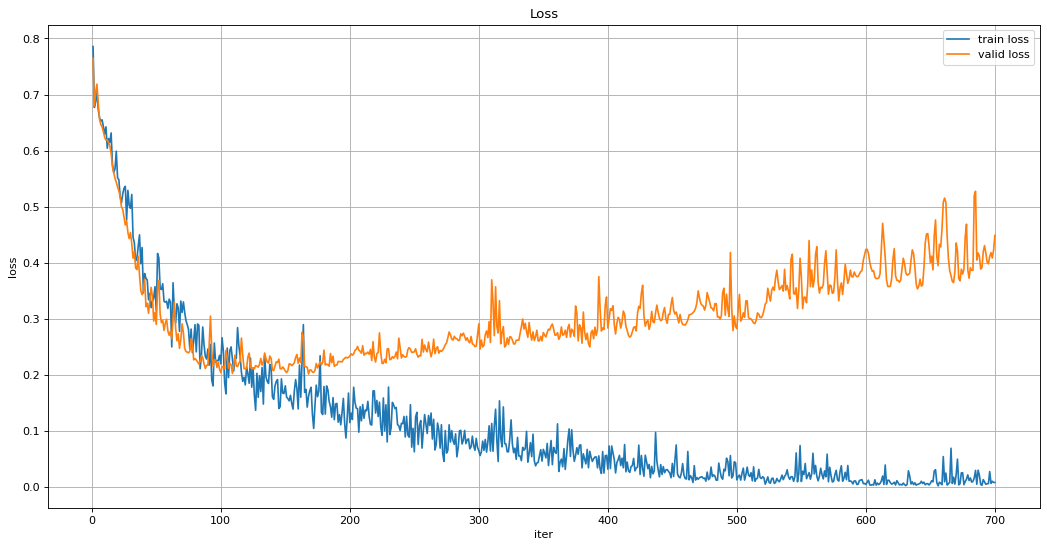

In [ ]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

## 9.2 Plot of training accuracy over iteration

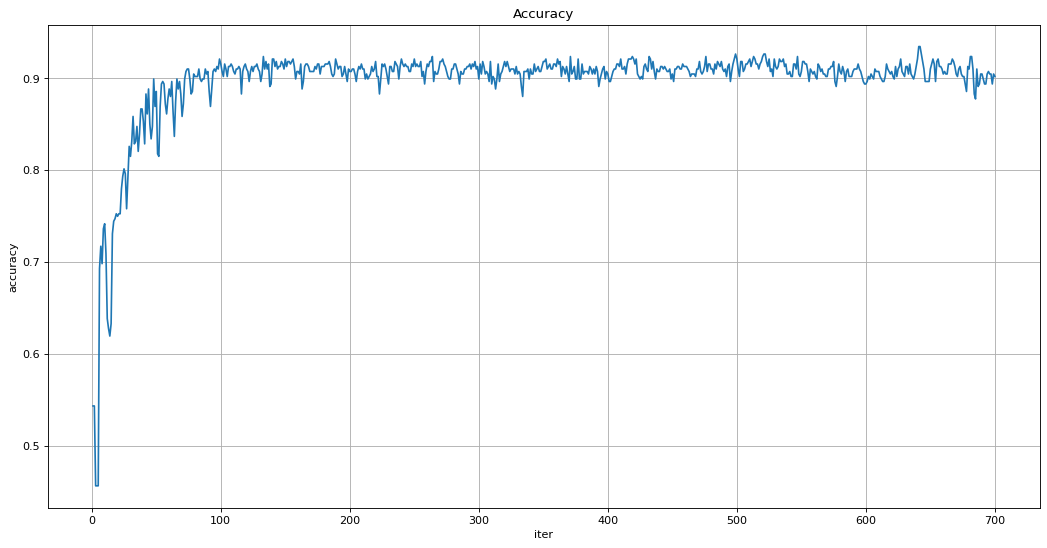

In [ ]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_acc, label = "train loss")
plt.title("Accuracy")
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.grid()
plt.show()

# **10. Advice**

Looking at the plot it is safe to say that the loss would have gone lower if we increase the number of iterations. I would advise to train the model using higher computational power to decrease iteration time and increase kernel time, an easy way to do that is by running the script on google cloud (such as dataflow) or amazon web service instances having high memory. Another advice I would give if you take the first advise is to increase the batch size to 500 to stabalize the optimization.